In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchvision import utils
import torchvision


from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import numpy as np
import time
import copy
import random
from tqdm.auto import tqdm
import math

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/jrobador/anaconda3/envs/INRIA/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
])

train = torchvision.datasets.MNIST(root = "./", train = True, download = True, transform = transforms)
test = torchvision.datasets.MNIST(root = "./", train = False, download = True, transform = transforms)

In [3]:
f_cnt, n_cnt = 0, 0
train_four, train_nine = [], []
test_four, test_nine = [], []

def transform_degree_n6(img):
    return torchvision.transforms.functional.rotate(img = img, angle = -6)

def transform_degree_n3(img):
    return torchvision.transforms.functional.rotate(img = img, angle = -3)

def transform_degree_3(img):
    return torchvision.transforms.functional.rotate(img = img, angle = 3)

def transform_pixel(img):
    for i in range(6):
       coord = np.random.randint(0, img.shape[1], size = 2)
       img[0, coord[0], coord[1]] = 0
    
    return img

def aug_func(idx, img):
    if i == 0: img = transform_degree_n6(img)
    if i == 1: img = transform_degree_n3(img)
    if i == 2: img = transform_degree_3(img)
    if i == 3: img = transform_pixel(img)
    return img

for img, label in train:
    if label == 4:

        if f_cnt < 3000: 
            train_four.append(img)
            for i in range(0, 4): train_four.append(aug_func(i, img))
            f_cnt+=1

        elif f_cnt < 4000: test_four.append(img); f_cnt+=1
    
    elif label == 9: 
        if n_cnt < 3000: 
            train_nine.append(img)
            for i in range(0, 4): train_nine.append(aug_func(i, img))
            n_cnt+=1
        elif n_cnt < 4000: test_nine.append(img); n_cnt+=1

/home/jrobador/anaconda3/envs/INRIA/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
test_four, test_nine = [], []
f_cnt, n_cnt = 0, 0

for img, label in test:
    if label == 4 and f_cnt < 900: # test nine has not enough images
        test_four.append(img)
        f_cnt += 1
    
    elif label == 9 and n_cnt < 900:
        test_nine.append(img)
        n_cnt += 1

print (len(test_four))

900


torch.Size([1, 32, 32])


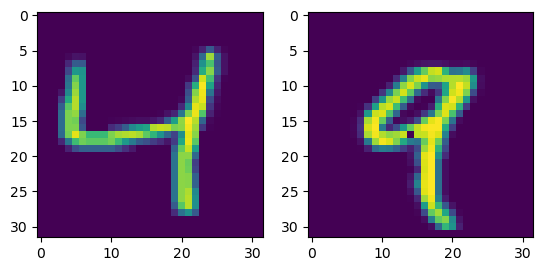

In [5]:
for f, n in zip(train_four, train_nine):
    plt.subplot(1, 2, 1); plt.imshow(f.permute(1,2,0))
    plt.subplot(1, 2, 2); plt.imshow(n.permute(1,2,0))    
    print(f.shape)
    break

In [16]:
train_f = [(img, 0) for img in train_four]
train_n = [(img, 1) for img in train_nine]

test_f = [(img, 0) for img in test_four]
test_n = [(img, 1) for img in test_nine]

train = train_f + train_n
test = test_f + test_n

random.shuffle(train)
random.shuffle(test)

traindata = [(img1[0], img2[0], 0) if img1[1] == img2[1] else (img1[0], img2[0], 1) for img1, img2 in zip(train[0::2], train[1::2])]

<class 'list'>


In [7]:
## ENCODER NETWORK

class DrLIM(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(in_channels = 1, out_channels = 15, kernel_size = 6, padding = 0, stride = 1)
        self.relu = nn.ReLU()
        self.subsampling = nn.MaxPool2d(kernel_size = 3, stride = 3)
        self.layer2 = nn.Conv2d(in_channels = 15, out_channels = 30, kernel_size = 9, padding = 0, stride = 1)
        self.fc = nn.Linear(15, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.subsampling(x)
        x = self.layer2(x)
       
        x = self.relu(x)
        x = self.fc(x)
        return x
    

In [8]:
def CL_Loss(x1, x2, Y, m = 1):
    Euclidean_norm = torch.sqrt((x1 - x2)**2) # Euclidean Distance
    return torch.mean((1-Y).reshape(-1, 1, 1) * 1/2 * Euclidean_norm**2 + Y.reshape(-1, 1, 1) * 1/2 * torch.maximum(torch.Tensor([0]).to(device), m - Euclidean_norm)**2)

In [19]:
trainloader = DataLoader(traindata[3000:], batch_size=128, shuffle=True)
validloader = DataLoader(traindata[:3000], batch_size=128, shuffle=True)
trainloader.__len__(), validloader.__len__()
tqdm(validloader)

  0%|          | 0/24 [00:00<?, ?it/s]

In [10]:
epochs = 200 # Iteration Number
cnt = 0      # early stopping count

model = DrLIM().to(device)
# criterion = CL_Loss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# save train and val Loss
train_loss = torch.zeros(epochs)
val_loss = torch.zeros(epochs)

# save train and val Acc
train_acc = torch.zeros(epochs)
val_acc = torch.zeros(epochs)

# initial loss value is inf.
valid_loss_min = np.Inf
valid_acc_max = 0

# train
for epoch in range(epochs):
    
    model.train() # train mode 
    
    for x1, x2, y in tqdm(trainloader):
        y = torch.tensor(y, dtype = torch.float64).to(device)
        x1, x2 = x1.to(device), x2.to(device)
        optimizer.zero_grad() # optimizer initialization
        
        Gw_x1 = model(x1) # model output of x1
        Gw_x2 = model(x2) # model output of x2
        
        # Calculate accuracy
        loss = CL_Loss(Gw_x1, Gw_x2, y) 
        loss.backward()
        optimizer.step() 
        train_loss[epoch] += loss.item()

        ans = torch.tensor((Gw_x1[:, 0] < Gw_x1[:, 1]) != (Gw_x2[:, 0] < Gw_x2[:, 1]), dtype=torch.float64) # Similar to Contrastive Leaning Loss
        equals = ans == y.reshape(ans.shape)   # calculate acc
        train_acc[epoch] += torch.mean(equals.type(torch.FloatTensor)).item()  
   
    # AVG Loss
    train_loss[epoch] /= len(trainloader)
    train_acc[epoch] /= len(trainloader)

    
    # valid , 
    model.eval()  
    with torch.no_grad():  
        for x1, x2, y in tqdm(validloader):
            y = torch.tensor(y, dtype = torch.float64).to(device)
            x1, x2 = x1.to(device), x2.to(device)

            Gw_x1 = model(x1)
            Gw_x2 = model(x2)

            loss = CL_Loss(Gw_x1, Gw_x2, y) 
            val_loss[epoch] += loss.item()

            
            ans = torch.tensor((Gw_x1[:, 0] < Gw_x1[:, 1]) != (Gw_x2[:, 0] < Gw_x2[:, 1]), dtype=torch.float64)
            equals = ans == y.reshape(ans.shape)  
            val_acc[epoch] += torch.mean(equals.type(torch.FloatTensor)).item() 
            
    val_loss[epoch] /= len(validloader)
    val_acc[epoch] /= len(validloader)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss[epoch]:.3f}.. "
          f"Train acc: {train_acc[epoch]:.3f}.. "
          f"val loss: {val_loss[epoch]:.3f}.. "
          f"val accuracy: {val_acc[epoch]:.3f}")

    if val_acc[epoch] >= valid_acc_max:
        print('Validation acc increased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_acc_max,
        val_acc[epoch]))
        torch.save(model.state_dict(), 'DrLIM.pt')

        valid_acc_max = val_acc[epoch]
        cnt = 0


    if cnt >= 10:
        print("Early Stopping")
        break
            
    cnt+=1 

  0%|          | 0/94 [00:00<?, ?it/s]

/tmp/ipykernel_169220/703325166.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype = torch.float64).to(device)
/tmp/ipykernel_169220/703325166.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ans = torch.tensor((Gw_x1[:, 0] < Gw_x1[:, 1]) != (Gw_x2[:, 0] < Gw_x2[:, 1]), dtype=torch.float64) # Similar to Contrastive Leaning Loss


  0%|          | 0/24 [00:00<?, ?it/s]

/tmp/ipykernel_169220/703325166.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype = torch.float64).to(device)
/tmp/ipykernel_169220/703325166.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ans = torch.tensor((Gw_x1[:, 0] < Gw_x1[:, 1]) != (Gw_x2[:, 0] < Gw_x2[:, 1]), dtype=torch.float64)


Epoch 1/200.. Train loss: 0.233.. Train acc: 0.509.. val loss: 0.227.. val accuracy: 0.529
Validation acc increased (0.000000 --> 0.529436).  Saving model ...


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/200.. Train loss: 0.226.. Train acc: 0.546.. val loss: 0.221.. val accuracy: 0.549
Validation acc increased (0.529436 --> 0.549293).  Saving model ...


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/200.. Train loss: 0.218.. Train acc: 0.583.. val loss: 0.213.. val accuracy: 0.576
Validation acc increased (0.549293 --> 0.575614).  Saving model ...


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4/200.. Train loss: 0.210.. Train acc: 0.596.. val loss: 0.205.. val accuracy: 0.585
Validation acc increased (0.575614 --> 0.585426).  Saving model ...


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/200.. Train loss: 0.202.. Train acc: 0.605.. val loss: 0.197.. val accuracy: 0.588
Validation acc increased (0.585426 --> 0.587565).  Saving model ...


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6/200.. Train loss: 0.194.. Train acc: 0.602.. val loss: 0.190.. val accuracy: 0.583


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7/200.. Train loss: 0.187.. Train acc: 0.603.. val loss: 0.182.. val accuracy: 0.586


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8/200.. Train loss: 0.180.. Train acc: 0.602.. val loss: 0.176.. val accuracy: 0.587


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9/200.. Train loss: 0.173.. Train acc: 0.601.. val loss: 0.169.. val accuracy: 0.585


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10/200.. Train loss: 0.167.. Train acc: 0.601.. val loss: 0.164.. val accuracy: 0.595
Validation acc increased (0.587565 --> 0.594727).  Saving model ...


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11/200.. Train loss: 0.162.. Train acc: 0.598.. val loss: 0.159.. val accuracy: 0.595
Validation acc increased (0.594727 --> 0.595331).  Saving model ...


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12/200.. Train loss: 0.157.. Train acc: 0.599.. val loss: 0.155.. val accuracy: 0.598
Validation acc increased (0.595331 --> 0.598447).  Saving model ...


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13/200.. Train loss: 0.153.. Train acc: 0.601.. val loss: 0.151.. val accuracy: 0.597


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14/200.. Train loss: 0.150.. Train acc: 0.601.. val loss: 0.148.. val accuracy: 0.600
Validation acc increased (0.598447 --> 0.600214).  Saving model ...


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15/200.. Train loss: 0.146.. Train acc: 0.603.. val loss: 0.145.. val accuracy: 0.599


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16/200.. Train loss: 0.144.. Train acc: 0.601.. val loss: 0.142.. val accuracy: 0.598


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17/200.. Train loss: 0.141.. Train acc: 0.598.. val loss: 0.141.. val accuracy: 0.592


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18/200.. Train loss: 0.139.. Train acc: 0.597.. val loss: 0.138.. val accuracy: 0.594


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19/200.. Train loss: 0.137.. Train acc: 0.599.. val loss: 0.136.. val accuracy: 0.596


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20/200.. Train loss: 0.135.. Train acc: 0.598.. val loss: 0.134.. val accuracy: 0.593


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21/200.. Train loss: 0.133.. Train acc: 0.596.. val loss: 0.132.. val accuracy: 0.594


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22/200.. Train loss: 0.131.. Train acc: 0.597.. val loss: 0.130.. val accuracy: 0.591


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23/200.. Train loss: 0.129.. Train acc: 0.594.. val loss: 0.128.. val accuracy: 0.588


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24/200.. Train loss: 0.126.. Train acc: 0.594.. val loss: 0.126.. val accuracy: 0.584
Early Stopping


  0%|          | 0/1800 [00:00<?, ?it/s]

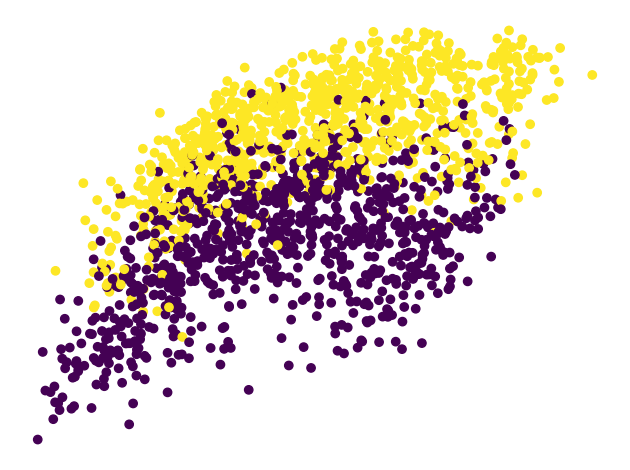

In [11]:
# valid , 
model = DrLIM().to(device)
model = nn.DataParallel(model).to(device)
model.module.load_state_dict(torch.load("./DrLIM.pt"))
model.eval()  

X, Y = None, []

with torch.no_grad():  
    for img, labels in tqdm(test):
        labels = torch.tensor(labels, dtype = torch.float64).to(device)
        img = img.to(device)
        
        output = model(img)

        if X is None:
            X = output
            Y.append(labels.item())
        else:
            X = torch.cat([X, output], dim=0)
            Y.append(labels.item())

X = X.detach().cpu().numpy()
y = np.array(Y)


plt.figure()
plt.axis('off')
plt.tight_layout()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.savefig('result.png') 